# Comparacion de algoritmos para deteccion y correccion de armonicos

En este documento se trataran distintos metodos para llegar a un algortimo que sea eficiente para corregir los armonicos de una señal de linea. La idea es que mediante este algortimo se puedan detectar los armonicos que haya en la corriente de la red y luego mediante la inyeccion de esta señal en contra fase poder eliminar estos armonicos indeseados consiguiendo un mejor factor de potencia.

La distorsión armónica deteriora el factor de potencia debido a la introducción de componentes de corriente y voltaje en frecuencias distintas a la fundamental. Estas componentes armónicas no contribuyen a la potencia activa, que es la potencia útil del sistema, pero sí incrementan la potencia aparente. El factor de potencia se define como la relación entre la potencia activa y la potencia aparente. Al aumentar la potencia aparente sin un aumento correspondiente en la potencia activa, el factor de potencia disminuye.


In [4]:
import sys
import os

# Add the libs directory to sys.path
libs_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'src')
sys.path.append(libs_path)

In [5]:
import numpy as np
from functions_AHF import * 
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

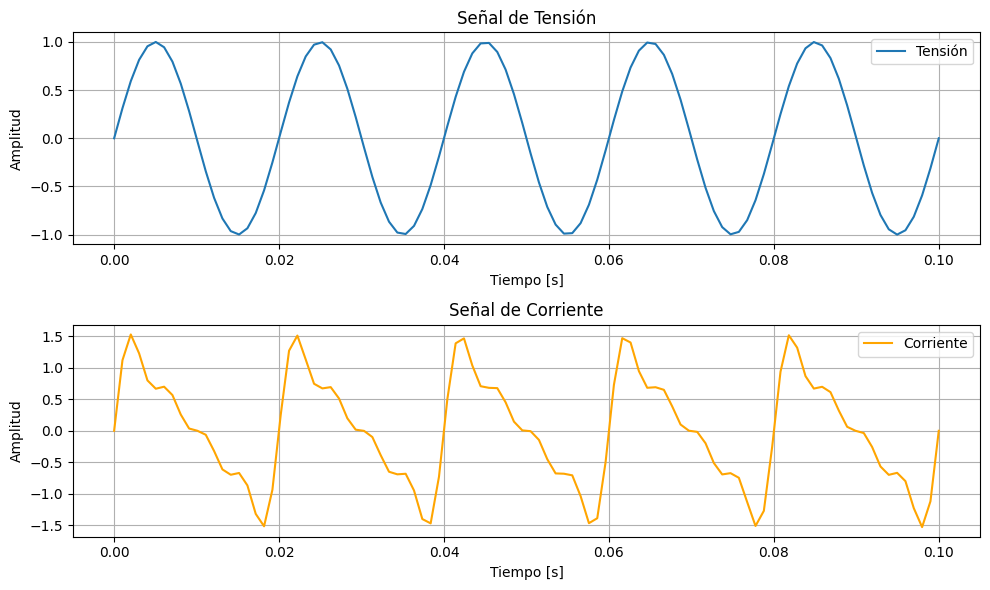

In [10]:
## Genero dos señales con la misma fundamental, la corriente tendra armonicos.
duracion = 0.1
fs = 1000

t = np.linspace(0,duracion,int(fs*duracion))
tension = Generar_señal_linea(t,f0 = 50,cant_armonicos=0,noise=False)
corriente = Generar_señal_linea(t,f0=50,cant_armonicos=5,noise=False)
plot_signals(tension,corriente,fs)

In [11]:
def get_señal_inyectar(corriente,fs):
    fft_signal = fft(corriente)/ len(corriente)
   
    # Calcular las frecuencias correspondientes a las muestras de la FFT
    frequencies = fftfreq(len(corriente), 1/fs)

    # Encontrar el índice del pico más alto en la magnitud de la FFT (excluyendo la frecuencia DC)
    fundamental_index = np.argmax(np.abs(fft_signal[1:])) + 1

    # Obtener la frecuencia fundamental y su fase
    f0 = frequencies[fundamental_index]
    fase = np.angle(fft_signal[fundamental_index])
    amplitud = np.abs(fft_signal[fundamental_index])
    t = np.linspace(0,len(corriente) * 1/fs,len(corriente))
    fundamental = amplitud * np.sin(2*np.pi*f0 * t + fase)
    return (corriente - fundamental)


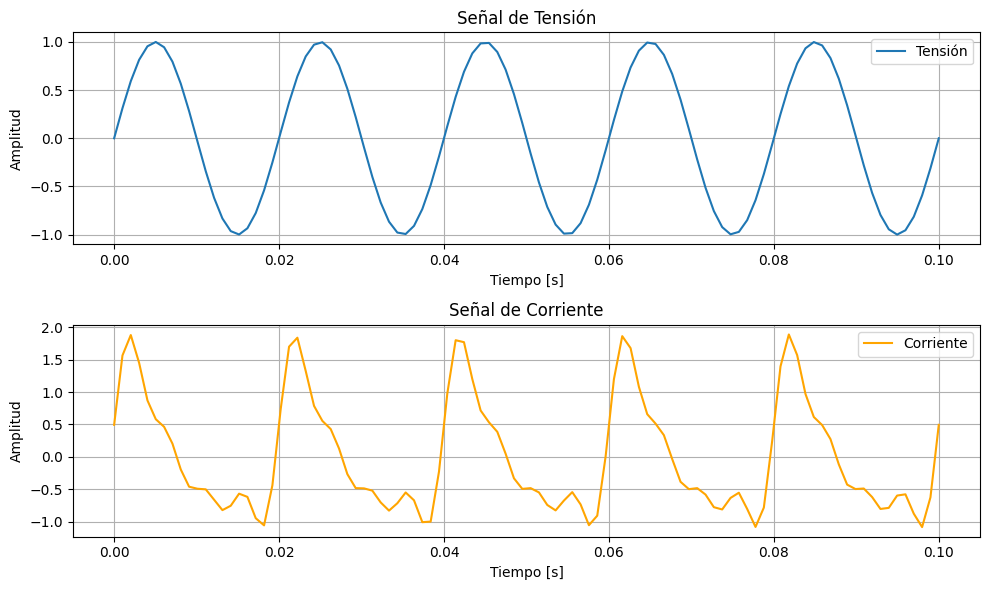

In [12]:
corriente_iny = get_señal_inyectar(corriente,fs)
plot_signals(tension,corriente_iny,fs)

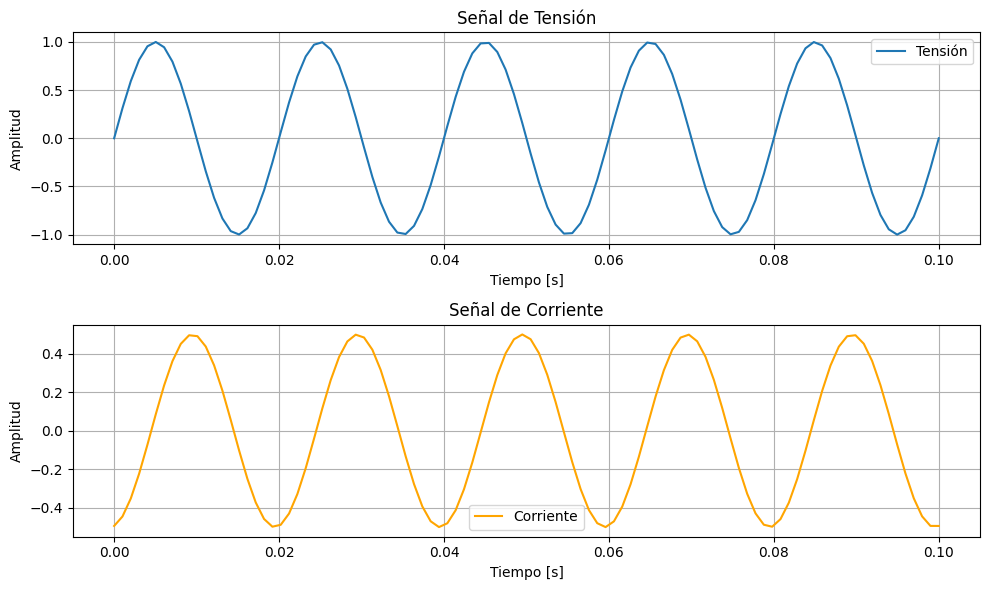

1.0040767824700285

In [13]:
plot_signals(tension,corriente - corriente_iny,fs)
thd= calcular_thd(corriente - corriente_iny,fs)
thd

Como se puede observar este metodo funciona y permite obtener la señal de corriente senoidal al inyectar la señal calculada por FFT. El problema de este metodo es el tiempo que tarda en hacerce el calculo de la FFT. 


A continuacion se muestra otra forma de llevar a cabo este procesamiento


In [6]:
from scipy.signal import firwin, lfilter

# Diseño un filtro pasa bajos con FC = 60Hz

# Frecuencia de corte del filtro (en Hz)
cutoff_frequency = 60

# Frecuencia de muestreo (en Hz)
fs = 1000

# Orden del filtro FIR
order = 30

# Diseñar el filtro pasa bajos FIR
taps = firwin(order + 1, cutoff=cutoff_frequency / (fs / 2), pass_zero=True)

# Funcion de filtrado (no uso lfilter por que es lento)
def filtro_fir(signal, taps):
    """
    Aplica un filtro FIR a una señal de entrada utilizando los coeficientes (taps) del filtro.

    Args:
    signal (array_like): Señal de entrada.
    taps (array_like): Coeficientes del filtro FIR.

    Returns:
    array_like: Señal filtrada.
    """
    # Invertir los coeficientes del filtro (taps)
    taps_invertidos = np.flip(taps)
    
    # Aplicar la convolución entre la señal de entrada y los coeficientes del filtro
    signal_filtrada = np.convolve(signal, taps_invertidos, mode='same')
    
    return signal_filtrada

def get_señal_inyectar_filtro(corriente,fs):
    filtered_signal = filtro_fir( corriente,taps)
    return (corriente - filtered_signal)


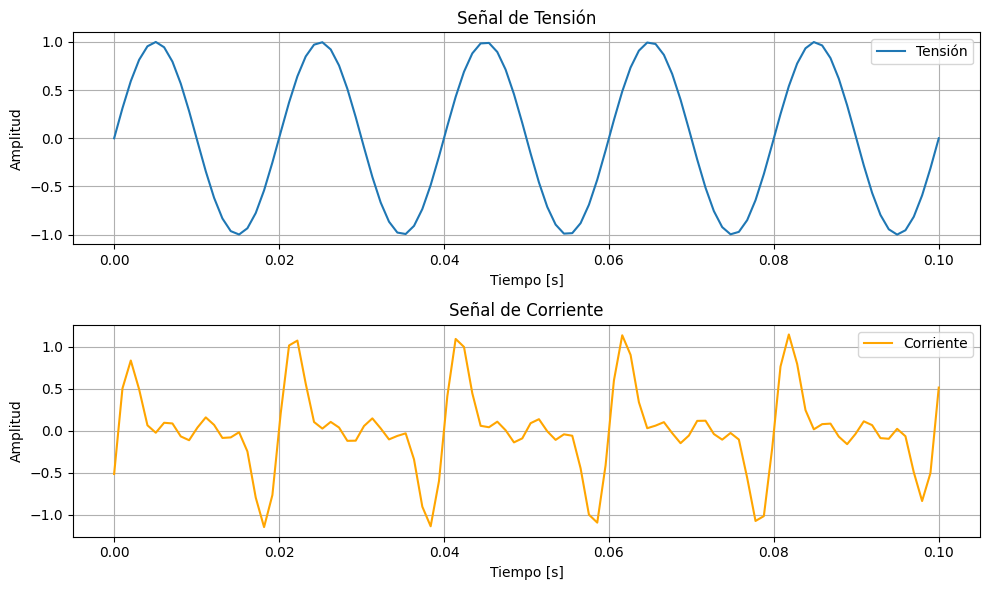

In [15]:
corriente_iny = get_señal_inyectar_filtro(corriente,fs)

plot_signals(tension,corriente_iny,fs)

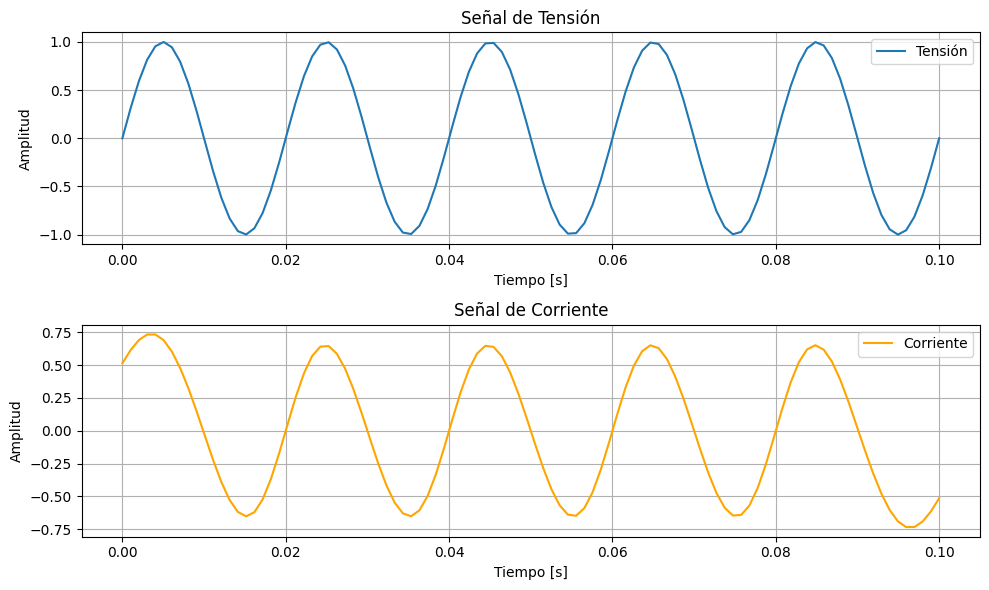

1.0283759989439916

In [16]:
plot_signals(tension,corriente - corriente_iny,fs)
calcular_thd(corriente - corriente_iny,fs)

In [17]:
# A continuacion se muestra la diferencia de tiempos entre cada metodo:

import timeit # Permite medir tiempos en forma muy eficiente

def metodo2():
    get_señal_inyectar_filtro(corriente,fs)
    
def metodo1():
    get_señal_inyectar(corriente,fs)

tiempo_transcurrido1 = float(timeit.timeit(metodo1, number=1))
tiempo_transcurrido2 = float(timeit.timeit(metodo2, number=1))

print(f"Con FFT el tiempo fue de: {tiempo_transcurrido1:.2e}, con el filtrado el tiempo fue de: {tiempo_transcurrido2:.2e}")

Con FFT el tiempo fue de: 4.80e-04, con el filtrado el tiempo fue de: 4.79e-05


Otra forma de llevar a cabo esto es mediante un filtro auto ajustable

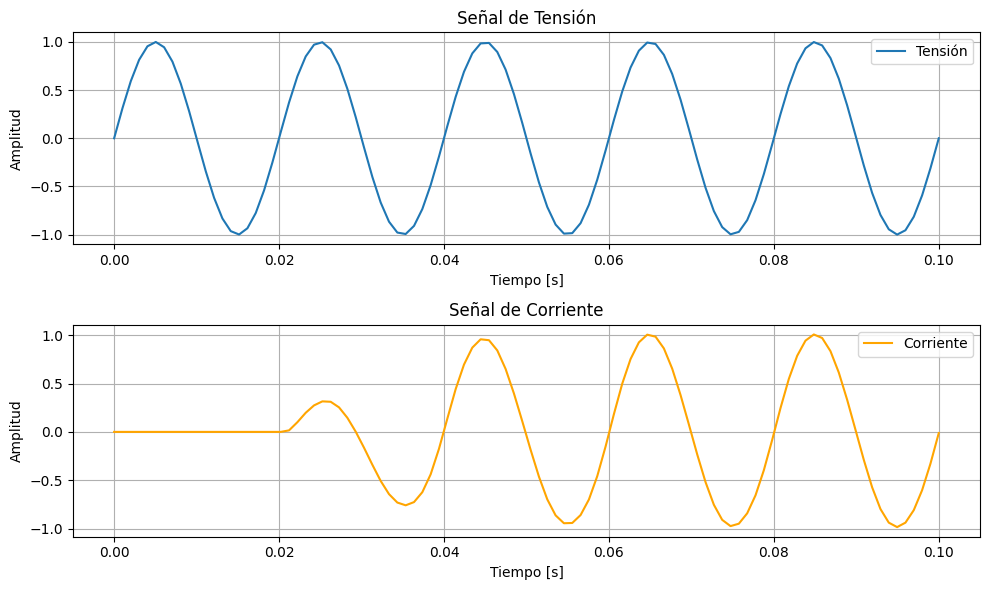

1.0028288484032195

In [18]:
# Implementación del filtro LMS
def lms_filter(x, d, mu, M):
    N = len(x)
    w = np.zeros(M)
    y = np.zeros(N)
    e = np.zeros(N)

    for n in range(M, N):
        x_n = x[n:n-M:-1]
        y[n] = np.dot(w, x_n)
        e[n] = d[n] - y[n]
        w = w + 2 * mu * e[n] * x_n
    
    return x-y, e

# Parámetros del filtro LMS
mu = 0.01
M = 20
d = Generar_señal_linea(t,50,0)

corriente_iny,_ = lms_filter(corriente,d,mu,M)
plot_signals(tension,corriente - corriente_iny,fs)

muestra = int(0.06 * fs)
señal_corregida = (corriente - corriente_iny)[muestra:-1]
calcular_thd(señal_corregida,fs)

In [19]:
def metodo1():
    lms_filter(corriente,d,mu,M)

tiempo_transcurrido1 = float(timeit.timeit(metodo1, number=1))
tiempo_transcurrido1
# Es lento porque tiene un for y tarda demasiado tiempo. Si pudiera llamar la funcion desde C seria mucho mas eficiente.

0.001184699998702854

Lo interesante de este metodo es que teniendo la señal de referencia que nosotros queramos podemos ahora adaptar el filtro exactamente a esa señal.
Por lo tanto si tenemos la señal de tension y en esta hay armonicos, no queremos eliminar esos armonicos de la corriente. Por lo que podemos tomar como referencia la tension, escalarla al valor de la fundamental de la corriente, ponerla en fase y luego usar esa señal como referencia para el filtro adaptativo


In [20]:
#TODO Ver como responde usando como referencia la tension
#TODO ver como responde este esquema con señales ruidosas
#TODO usar como señal de corriente una señal real de LTSPICE
#TODO Hacer tablas de valores de tiempos y THD para cada caso
